In [ ]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 26.6 MB/s eta 0:00:

In [ ]:
!nvidia-smi

Tue Apr 25 23:28:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from transformers import pipeline, set_seed
from transformers import BartTokenizer, BartModel, BartForConditionalGeneration, AutoTokenizer # bart

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
name = "facebook/bart-large-cnn" # bart base

# tokenizer_large = BartTokenizer.from_pretrained(name)
tokenizer_large = AutoTokenizer.from_pretrained(name)
# model_large = BartModel.from_pretrained(model_large).to(device)
model_large = BartForConditionalGeneration.from_pretrained(name).to(device)

In [ ]:
print(model_large)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerN

# Generate Distilled BART

https://github.com/huggingface/transformers/issues/6971


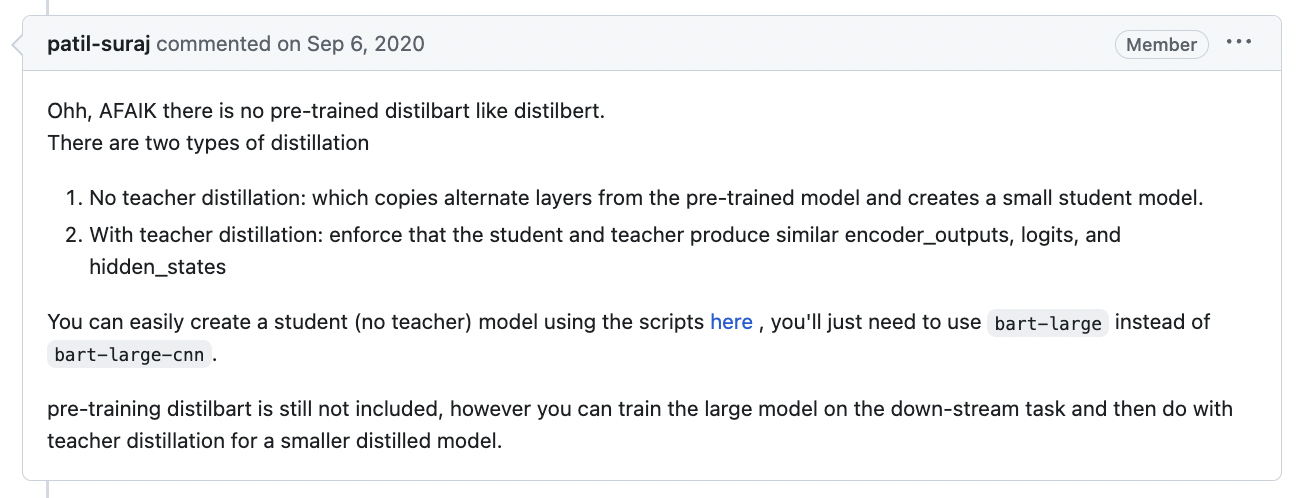

In [ ]:
!ls /content/drive

MyDrive  Shareddrives


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# code adapted from https://github.com/huggingface/transformers/blob/master/examples/seq2seq/distillation.py
# https://github.com/patil-suraj/distillbart-mnli/blob/master/create_student.py
# https://github.com/huggingface/transformers/blob/main/examples/research_projects/seq2seq-distillation/make_student.py

'''
using the No Teacher Distillation technique proposed for BART summarisation by Huggingface,
We just copy alternating layers from bart-large-mnli and finetune more on the same data.
'''

import argparse
import warnings
import os
from typing import List

from torch import nn
from transformers import BartForSequenceClassification, BartTokenizerFast

LAYERS_TO_COPY = {
    # maps  num layers in student -> which teacher layers to copy.
    # 12: bart, 16: pegasus, 6: marian/Helsinki-NLP
    12: {
        1: [0],
        2: [0, 6],
        3: [0, 6, 11],
        4: [0, 4, 8, 11],
        6: [0, 2, 4, 7, 9, 11],
        9: [0, 1, 2, 4, 5, 7, 9, 10, 11],
        12: list(range(12)),
    },
    16: {  # maps  num layers in student -> which teacher layers to copy
        1: [0],
        2: [0, 8],
        3: [0, 8, 15],
        4: [0, 5, 10, 15],
        6: [0, 3, 6, 9, 12, 15],
        8: [0, 2, 4, 6, 8, 10, 12, 15],
        9: [0, 1, 3, 5, 7, 9, 11, 13, 15],
        12: [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 13, 15],
        16: list(range(16)),
    },
    6: {1: [0], 2: [0, 5], 3: [0, 2, 5], 4: [0, 1, 3, 5], 6: list(range(6))},
}

LAYERS_TO_SUPERVISE = {
    12: {1: [11], 2: [5, 11], 3: [3, 7, 11], 6: [1, 3, 5, 8, 10, 11]},
    16: {1: [15], 4: [4, 9, 12, 15], 8: [1, 3, 5, 7, 9, 11, 13, 15]},
    6: {1: [5], 2: [3, 5], 3: [1, 4, 5], 4: [1, 2, 4, 5]},
    2: {1: [1], 2: [0, 1]},
}

def get_layers_to_copy(n_student, n_teacher):
    try:
        val = LAYERS_TO_COPY[n_teacher][n_student]
        # assert len(LAYERS_TO_SUPERVISE[n_teacher][n_student]) == len(val) == n_student
        return val
    except KeyError:
        if n_student != n_teacher:
            warnings.warn(
                f"no hardcoded layers to copy for teacher {n_teacher} -> student {n_student}, defaulting to first {n_student}"
            )
        return list(range(n_student))


def copy_to_student(d_layers_to_copy, e_layers_to_copy, student_encoder_layers, student_decoder_layers, student, teacher):
  different_encoder = (student_encoder_layers != teacher.config.encoder_layers)
  different_decoder = (student_decoder_layers != teacher.config.decoder_layers)
  if different_decoder:
      copy_layers(teacher.model.decoder.layers, student.model.decoder.layers, d_layers_to_copy)
  if different_encoder:
      copy_layers(teacher.model.encoder.layers, student.model.encoder.layers, e_layers_to_copy)


def copy_layers(src_layers: nn.ModuleList, dest_layers: nn.ModuleList, layers_to_copy: List[int]) -> None:
    layers_to_copy = nn.ModuleList([src_layers[i] for i in layers_to_copy])
    assert len(dest_layers) == len(layers_to_copy), f"{len(dest_layers)} != {len(layers_to_copy)}"
    dest_layers.load_state_dict(layers_to_copy.state_dict())


def create_student(teacher, student_encoder_layers, student_decoder_layers):
    teacher = BartForConditionalGeneration.from_pretrained(teacher).eval()
    student_updates = {
        "decoder_layers": student_decoder_layers,
        "encoder_layers": student_encoder_layers,
    }
    kw = teacher.config.to_diff_dict()
    kw.update(student_updates)

   
    # Copy weights
    student_cfg = teacher.config_class(**kw)
    student = type(teacher)(student_cfg)
    # student = BartForConditionalGeneration.from_config(student_cfg)
    info = student.load_state_dict(teacher.state_dict(), strict=False)
    assert info.missing_keys == [], info.missing_keys


    # Decide which layers of the teacher to copy. Not exactly alternating -- we try to keep first and last layer.
    e_layers_to_copy: List = get_layers_to_copy(student_updates["encoder_layers"], teacher.config.encoder_layers)
    d_layers_to_copy: List = get_layers_to_copy(student_updates["decoder_layers"], teacher.config.decoder_layers)
    copy_to_student(d_layers_to_copy, e_layers_to_copy, student_encoder_layers, student_decoder_layers, student, teacher)


    student.config.init_metadata = {
        "teacher_type": teacher.config.model_type,
        "copied_encoder_layers": e_layers_to_copy,
        "copied_decoder_layers": d_layers_to_copy,
    }


    return student

In [ ]:
student_encoder_layers, student_decoder_layers = 12, 3

student = create_student(name, student_encoder_layers, student_decoder_layers)

student.save_pretrained(f"/content/drive/MyDrive/dl-gp/BART-large-full-GPT/Distilled_{student_encoder_layers}_{student_decoder_layers}")

In [ ]:
f"/content/drive/MyDrive/dl-gp/BART-large-full-GPT/Distilled_{student_encoder_layers}_{student_decoder_layers}"

'/content/drive/MyDrive/dl-gp/BART-large-full-GPT/Distilled_12_3'

# LoadData

In [ ]:
dataset_xsum = load_dataset("samsum")

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset_samsum = dataset_xsum

In [ ]:
import numpy as np
import pandas as pd
import json

In [ ]:
gpt_load = np.load('/content/drive/MyDrive/dl-gp/samsum_ChatGPT_full-raoyi.npy', allow_pickle=True)

In [ ]:
len(gpt_load)

14732

In [ ]:
dataset_samsum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [ ]:
dataset_samsum["train"]

Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 14732
})

In [ ]:
type(dataset_samsum["train"]["id"])

list

In [ ]:
df = pd.DataFrame (dataset_samsum["train"]["id"], columns = ['id'])

In [ ]:
df['dialogue'] = dataset_samsum["train"]["dialogue"]

In [ ]:
df['samsum'] = dataset_samsum["train"]["summary"]

In [ ]:
gpt_list = gpt_load.tolist()

In [ ]:
df['gpt'] = gpt_list

In [ ]:
df = df.drop(columns=['id'])

In [ ]:
df.index

RangeIndex(start=0, stop=14732, step=1)

In [ ]:
df

,dialogue,samsum,gpt
0,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...,"Amanda offered Jerry some cookies, and he acce..."
1,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...,Olivia and Oliver both plan to vote for the Li...
2,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...,Kim was feeling bad after spending her day pro...
3,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...,Rachel abruptly interrupted Edward's confessio...
4,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com...","Sam overheard his roommate, Rick, talking on t..."
...,...,...,...
14727,Romeo: You are on my ‘People you may know’ lis...,Romeo is trying to get Greta to add him to her...,Romeo reached out to Greta as a potential frie...
14728,Theresa: <file_photo>\r\nTheresa: <file_photo>...,Theresa is at work. She gets free food and fre...,"Theresa shared photos of her workplace, and me..."
14729,John: Every day some bad news. Japan will hunt...,Japan is going to hunt whales again. Island an...,John expressed his outrage over Japan's decisi...
14730,Jennifer: Dear Celia! How are you doing?\r\nJe...,Celia couldn't make it to the afternoon with t...,Jennifer and Celia catch up on their social li...


In [ ]:
df2 = df.rename({'gpt': 'summary'}, axis='columns')
df2.head()

,dialogue,samsum,summary
0,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...,"Amanda offered Jerry some cookies, and he acce..."
1,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...,Olivia and Oliver both plan to vote for the Li...
2,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...,Kim was feeling bad after spending her day pro...
3,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...,Rachel abruptly interrupted Edward's confessio...
4,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com...","Sam overheard his roommate, Rick, talking on t..."


In [ ]:
type(df.index[0])

int

In [ ]:
# type(df.samsum[0])

In [ ]:
df2 = df2.reset_index()

In [ ]:
df2 = df2.astype({"index": int})

In [ ]:
df2 = df2.rename(columns={"index": "id"})

In [ ]:
df2.head()

,id,dialogue,samsum,summary
0,0,Amanda: I baked cookies. Do you want some?\r\...,Amanda baked cookies and will bring Jerry some...,"Amanda offered Jerry some cookies, and he acce..."
1,1,Olivia: Who are you voting for in this electio...,Olivia and Olivier are voting for liberals in ...,Olivia and Oliver both plan to vote for the Li...
2,2,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim may try the pomodoro technique recommended...,Kim was feeling bad after spending her day pro...
3,3,"Edward: Rachel, I think I'm in ove with Bella....",Edward thinks he is in love with Bella. Rachel...,Rachel abruptly interrupted Edward's confessio...
4,4,Sam: hey overheard rick say something\r\nSam:...,"Sam is confused, because he overheard Rick com...","Sam overheard his roommate, Rick, talking on t..."


# Fine Tune

In [ ]:
dfmix = df2[['id','dialogue','summary']]

In [ ]:
dfmix

,id,dialogue,summary
0,0,Amanda: I baked cookies. Do you want some?\r\...,"Amanda offered Jerry some cookies, and he acce..."
1,1,Olivia: Who are you voting for in this electio...,Olivia and Oliver both plan to vote for the Li...
2,2,"Tim: Hi, what's up?\r\nKim: Bad mood tbh, I wa...",Kim was feeling bad after spending her day pro...
3,3,"Edward: Rachel, I think I'm in ove with Bella....",Rachel abruptly interrupted Edward's confessio...
4,4,Sam: hey overheard rick say something\r\nSam:...,"Sam overheard his roommate, Rick, talking on t..."
...,...,...,...
14727,14727,Romeo: You are on my ‘People you may know’ lis...,Romeo reached out to Greta as a potential frie...
14728,14728,Theresa: <file_photo>\r\nTheresa: <file_photo>...,"Theresa shared photos of her workplace, and me..."
14729,14729,John: Every day some bad news. Japan will hunt...,John expressed his outrage over Japan's decisi...
14730,14730,Jennifer: Dear Celia! How are you doing?\r\nJe...,Jennifer and Celia catch up on their social li...


In [ ]:
dataset_samsum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [ ]:
from datasets import Dataset
dataset = Dataset.from_pandas(dfmix)

In [ ]:
dataset[100]

{'id': 100,
 'dialogue': "Gabby: How is you? Settling into the new house OK?\r\nSandra: Good. The kids and the rest of the menagerie are doing fine. The dogs absolutely love the new garden. Plenty of room to dig and run around.\r\nGabby: What about the hubby?\r\nSandra: Well, apart from being his usual grumpy self I guess he's doing OK.\r\nGabby: :-D yeah sounds about right for Jim.\r\nSandra: He's a man of few words. No surprises there. Give him a backyard shed and that's the last you'll see of him for months.\r\nGabby: LOL that describes most men I know.\r\nSandra: Ain't that the truth! \r\nGabby: Sure is. :-) My one might as well move into the garage. Always tinkering and building something in there.\r\nSandra: Ever wondered what he's doing in there?\r\nGabby: All the time. But he keeps the place locked.\r\nSandra: Prolly building a portable teleporter or something. ;-)\r\nGabby: Or a time machine... LOL\r\nSandra: Or a new greatly improved Rabbit :-P\r\nGabby: I wish... Lmfao!",
 '

In [ ]:
val_dataset = dataset_samsum['validation']

In [ ]:
val_dataset[0]

{'id': '13817023',
 'dialogue': "A: Hi Tom, are you busy tomorrow’s afternoon?\r\nB: I’m pretty sure I am. What’s up?\r\nA: Can you go with me to the animal shelter?.\r\nB: What do you want to do?\r\nA: I want to get a puppy for my son.\r\nB: That will make him so happy.\r\nA: Yeah, we’ve discussed it many times. I think he’s ready now.\r\nB: That’s good. Raising a dog is a tough issue. Like having a baby ;-) \r\nA: I'll get him one of those little dogs.\r\nB: One that won't grow up too big;-)\r\nA: And eat too much;-))\r\nB: Do you know which one he would like?\r\nA: Oh, yes, I took him there last Monday. He showed me one that he really liked.\r\nB: I bet you had to drag him away.\r\nA: He wanted to take it home right away ;-).\r\nB: I wonder what he'll name it.\r\nA: He said he’d name it after his dead hamster – Lemmy  - he's  a great Motorhead fan :-)))",
 'summary': 'A will go to the animal shelter tomorrow to get a puppy for her son. They already visited the shelter last Monday an

In [ ]:
import datasets
dd = datasets.DatasetDict({"train":dataset,"validation":val_dataset})

In [ ]:
dd

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer_large(example_batch['dialogue'] , max_length = 1024, truncation = True )
    
    with tokenizer_large.as_target_tokenizer():
        target_encodings = tokenizer_large(example_batch['summary'], max_length = 128, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }
    
dataset_samsum_pt = dd.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
dataset_samsum_pt['train'][0]

{'id': 0,
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda offered Jerry some cookies, and he accepted. Amanda promised to bring them to him the next day.',
 'input_ids': [0,
  10127,
  5219,
  35,
  38,
  17241,
  1437,
  15269,
  4,
  1832,
  47,
  236,
  103,
  116,
  50121,
  50118,
  39237,
  35,
  9136,
  328,
  50121,
  50118,
  10127,
  5219,
  35,
  38,
  581,
  836,
  47,
  3859,
  48433,
  2],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [0,
  10127,
  5219,
  1661,
  6509,
  103,
  15269,
  6,
  8,
  37,
  3903,
  4,
  10641,
  3604,
  7,
  836,
  106,
  7,
  123,
  5,
  220,
  183,
  4,
  2]}

In [ ]:
dataset_val = dataset_samsum["validation"].map(convert_examples_to_features, batched = True)

In [ ]:
dataset_samsum_pt['validation'][0]

{'id': '13817023',
 'dialogue': "A: Hi Tom, are you busy tomorrow’s afternoon?\r\nB: I’m pretty sure I am. What’s up?\r\nA: Can you go with me to the animal shelter?.\r\nB: What do you want to do?\r\nA: I want to get a puppy for my son.\r\nB: That will make him so happy.\r\nA: Yeah, we’ve discussed it many times. I think he’s ready now.\r\nB: That’s good. Raising a dog is a tough issue. Like having a baby ;-) \r\nA: I'll get him one of those little dogs.\r\nB: One that won't grow up too big;-)\r\nA: And eat too much;-))\r\nB: Do you know which one he would like?\r\nA: Oh, yes, I took him there last Monday. He showed me one that he really liked.\r\nB: I bet you had to drag him away.\r\nA: He wanted to take it home right away ;-).\r\nB: I wonder what he'll name it.\r\nA: He said he’d name it after his dead hamster – Lemmy  - he's  a great Motorhead fan :-)))",
 'summary': 'A will go to the animal shelter tomorrow to get a puppy for her son. They already visited the shelter last Monday an

In [ ]:
from transformers import DataCollatorForSeq2Seq

student = student.to(device)
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer_large, model=student)

In [ ]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='bart-gpt-full-2', num_train_epochs=3, warmup_steps=500,
    per_device_train_batch_size=8, per_device_eval_batch_size=4,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=125, save_steps=125,
    gradient_accumulation_steps=16
) 
     

In [ ]:
trainer = Trainer(model=student, args=trainer_args,
                  tokenizer=tokenizer_large, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt['train'], 
                  eval_dataset=dataset_samsum_pt['validation'])

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
125,3.042700,2.798586
250,2.240600,2.482543


TrainOutput(global_step=345, training_loss=3.357341105696084, metrics={'train_runtime': 1297.6383, 'train_samples_per_second': 34.059, 'train_steps_per_second': 0.266, 'total_flos': 1.86278834079744e+16, 'train_loss': 3.357341105696084, 'epoch': 3.0})

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer

output_dir = 'bart-gpt-full-3'  # specify the output directory used during training

# load the saved model
student1 = BartForConditionalGeneration.from_pretrained(output_dir + '/checkpoint-125')

In [ ]:
student1.save_pretrained("/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-large-model-distilled-12-3")
tokenizer_large.save_pretrained("/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-tokenizer-distilled-12-3")

('/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-tokenizer-distilled-12-3/tokenizer_config.json',
 '/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-tokenizer-distilled-12-3/special_tokens_map.json',
 '/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-tokenizer-distilled-12-3/vocab.json',
 '/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-tokenizer-distilled-12-3/merges.txt',
 '/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-tokenizer-distilled-12-3/added_tokens.json',
 '/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-tokenizer-distilled-12-3/tokenizer.json')

In [ ]:
trainer

# Reload the saved model

In [ ]:
tokenizer_large = AutoTokenizer.from_pretrained("/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-tokenizer-distilled-12-6-2epochs")
# model_large = BartModel.from_pretrained(model_large).to(device)
student = BartForConditionalGeneration.from_pretrained("/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-large-model-distilled-12-6-2epochs").to(device)

In [ ]:
trainer_args = TrainingArguments(
    output_dir='bart-gpt-full-3', num_train_epochs=3, warmup_steps=500,
    per_device_train_batch_size=8, per_device_eval_batch_size=4,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=125, save_steps=125,
    gradient_accumulation_steps=16
) 
     

In [ ]:
trainer = Trainer(model=student, args=trainer_args,
                    tokenizer=tokenizer_large, data_collator=seq2seq_data_collator,
                    train_dataset=dataset_samsum_pt['train'], 
                    eval_dataset=dataset_samsum_pt['validation'])

trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
125,1.871000,2.389472
250,1.666500,2.416953


KeyboardInterrupt: ignored

In [ ]:
model_large.save_pretrained("/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-large-model-1")
tokenizer_large.save_pretrained("/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-tokenizer-1")

('/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-tokenizer-1/tokenizer_config.json',
 '/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-tokenizer-1/special_tokens_map.json',
 '/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-tokenizer-1/vocab.json',
 '/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-tokenizer-1/merges.txt',
 '/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-tokenizer-1/added_tokens.json',
 '/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-tokenizer-1/tokenizer.json')

# Test  -- Rouge1, Rouge2, RougeL, BertScore

## RougeX

In [ ]:
dataset_dia = load_dataset("knkarthick/dialogsum")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/knkarthick___csv/knkarthick--dialogsum-c8fac5d84cd35861/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
newtest = pd.DataFrame (dataset_dia["test"]["id"], columns = ['id'])
newtest['dialogue'] = dataset_dia["test"]["dialogue"]
newtest['summary'] = dataset_dia["test"]["summary"]

In [ ]:
newtest = newtest.iloc[200:700]

In [ ]:
class newtest_test(torch.utils.data.Dataset):
    def __init__(self, df):
        self.data = df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.data.iloc[idx].dialogue , self.data.iloc[idx].summary

newtest_loader = newtest_test(newtest)

In [ ]:
tokenizer_large = BartTokenizer.from_pretrained("/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-tokenizer-distilled-12-6-2epochs")
model_large = BartForConditionalGeneration.from_pretrained("/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-large-model-distilled-12-6-2epochs").to(device)

In [ ]:
student1 = student1.to(device)

In [ ]:
from rouge_score import rouge_scorer 


results = {'rouge1': np.zeros(3), 'rouge2': np.zeros(3), 'rougeL': np.zeros(3)}

for data in tqdm(newtest_loader,position=0, leave=True):
  article, ref = data

  inputs = tokenizer_large(article, return_tensors="pt", max_length=1024).to(device)
  summary_ids = student1.generate(inputs["input_ids"], num_beams=2, min_length=0, max_length=100)
  
  res = tokenizer_large.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL', 'rouge2'], use_stemmer=True)
  scores = scorer.score(res, ref)
  for key in scores.keys():
    results[key] += np.array(scores[key])

100%|██████████| 500/500 [02:23<00:00,  3.48it/s]


In [ ]:
# average over all test data
for key in results.keys(): 
  results[key] /= len(newtest)
results

{'rouge1': array([0.49075121, 0.2741565 , 0.34197255]),
 'rouge2': array([0.18565214, 0.10241243, 0.1281841 ]),
 'rougeL': array([0.38746343, 0.21534675, 0.26924986])}

In [ ]:
# Print Average F1 metrics 
print("average R1: ", results['rouge1'][2])
print("average R2: ", results['rouge2'][2])
print("average RL: ", results['rougeL'][2])

average R1:  0.34197255204965116
average R2:  0.12818410251483675
average RL:  0.26924985847325433


In [ ]:
# encoder - 12, decoder - 12

# 0.386392477
# 0.151505164
# 0.308956318

## BertScore

In [ ]:
!pip install evaluate
!pip install bert_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.4 MB/s eta 0:00:00


In [ ]:
from evaluate import load
bertscore = load("bertscore")

In [ ]:
gen_kwargs_gpt = {"length_penalty": 0.6, "num_beams":8, "max_length": 128}
pipe_gpt = pipeline("summarization", model="/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bart-large-model-distilled-12-3",tokenizer=tokenizer_large)

In [ ]:
newtest_summary_list = newtest.summary.to_list()
newtest_dialogue_list = newtest.dialogue.to_list()

gpt_list = []

In [ ]:
for i in range(len(newtest_dialogue_list)):
  if i % 50 == 0:
    print(str(i))
  sample_text = newtest_dialogue_list[i]

  out_gpt = pipe_gpt(sample_text, **gen_kwargs_gpt)[0]["summary_text"]
  gpt_list.append(out_gpt)

0


Your max_length is set to 128, but you input_length is only 108. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 128, but you input_length is only 108. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 128, but you input_length is only 108. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)


50


Your max_length is set to 128, but you input_length is only 81. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 128, but you input_length is only 81. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 128, but you input_length is only 81. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 128, but you input_length is only 95. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 128, but you input_length is only 95. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 128, but you input_length is only 95. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)


100


Your max_length is set to 128, but you input_length is only 89. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 128, but you input_length is only 89. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 128, but you input_length is only 89. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 128, but you input_length is only 89. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 128, but you input_length is only 89. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 128, but you input_length is only 89. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 128, but you input_length is only 92. You might consider

150


Your max_length is set to 128, but you input_length is only 116. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 128, but you input_length is only 116. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 128, but you input_length is only 116. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 128, but you input_length is only 73. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 128, but you input_length is only 73. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 128, but you input_length is only 73. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 128, but you input_length is only 92. You might consi

200


Your max_length is set to 128, but you input_length is only 108. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 128, but you input_length is only 108. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 128, but you input_length is only 108. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Your max_length is set to 128, but you input_length is only 86. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 128, but you input_length is only 86. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 128, but you input_length is only 86. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Your max_length is set to 128, but you input_length is only 86. You might consi

250


Your max_length is set to 128, but you input_length is only 80. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 128, but you input_length is only 80. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 128, but you input_length is only 80. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Your max_length is set to 128, but you input_length is only 88. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 128, but you input_length is only 88. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 128, but you input_length is only 88. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 128, but you input_length is only 127. You might conside

300


Your max_length is set to 128, but you input_length is only 117. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 128, but you input_length is only 117. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 128, but you input_length is only 117. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 128, but you input_length is only 99. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 128, but you input_length is only 99. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 128, but you input_length is only 99. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Your max_length is set to 128, but you input_length is only 85. You might consi

350


Your max_length is set to 128, but you input_length is only 63. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 128, but you input_length is only 63. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 128, but you input_length is only 63. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)
Your max_length is set to 128, but you input_length is only 124. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)
Your max_length is set to 128, but you input_length is only 124. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)
Your max_length is set to 128, but you input_length is only 124. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)
Your max_length is set to 128, but you input_length is only 105. You might cons

400


Your max_length is set to 128, but you input_length is only 94. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 128, but you input_length is only 94. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 128, but you input_length is only 94. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Your max_length is set to 128, but you input_length is only 102. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 128, but you input_length is only 102. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 128, but you input_length is only 102. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 128, but you input_length is only 79. You might consi

450


Your max_length is set to 128, but you input_length is only 117. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 128, but you input_length is only 117. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 128, but you input_length is only 117. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=58)
Your max_length is set to 128, but you input_length is only 106. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 128, but you input_length is only 106. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 128, but you input_length is only 106. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 128, but you input_length is only 67. You might co

In [ ]:
predictions_all_gpt = gpt_list
references = newtest_summary_list
results_all_gpt = bertscore.compute(predictions=predictions_all_gpt, references=references, lang="en")

In [ ]:
with open("/content/drive/MyDrive/dl-gp/BART-large-full-GPT/bertscore-distilled-12-3_all_samsum.json", "w") as outfile:
    json.dump(results_all_gpt, outfile)

In [ ]:
pd.DataFrame(results_all_gpt).describe()

,precision,recall,f1
count,500.000000,500.000000,500.000000
mean,0.869785,0.894450,0.881825
std,0.016755,0.020302,0.015431
min,0.827309,0.832713,0.831717
25%,0.859154,0.881916,0.871413
50%,0.869830,0.893435,0.881871
75%,0.881441,0.907935,0.891697
max,0.917202,0.971053,0.942670
